# Data Engineering Project
# AgriTech - USGS LIDAR Challenge
This notebook presents code to connect to the USGS 3DEPP API, query the data model to select with a specified input and load the data into a geopandas .

In [21]:
import pdal
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point, mapping
import numpy as np
from pyproj import Proj, transform
import folium
import laspy as lp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

### Initial configuration for fetching the data from AWS
During the initial configuration, we set the path to json file that is used to build the pdal pipeline, we also set the url to the lidar data on Amazon and the state/region

In [2]:
json_path = "pdal.json"  #path to the json file for building the pdal pipeline
url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public"   # url to the public lidar data on Amazon
region = "IA_FullState"  # the region we will be working with
in_srs = 3857   # coordinate reference system used in the data on Amazon
out_srs = 4326  # coordinate reference system we are going to use in the code. 

### Utility functions definition
We define utility functions we will use when fetching the data

In [4]:
def read_json(json_path: str)->json:
    """
    This function loads a json file from a specified path into a json object
    
    params:
        json_path (str): the path to the json file
        
    returns:
        json object loaded from the json file
    """
    try:
        with open(json_path) as js:
            json_obj = json.load(js)
        return json_obj

    except FileNotFoundError:
        print('File not found.')

In [5]:
def convert_EPSG(lon, lat, crs) -> list:
    """
    This function converts a coordinate from one coordinate system to another. The function can convert the coordinates from epsg 3857 coordinate system to epsg 4326 coordinate system and vice versa
    
    params:
        lon (double): the longitude value of the coordinate
        lat (double): the latitude value of the coordinate
        crs (int): the coordinate reference system of the coordinate to be converted
    
    returns: 
        A list of two values indicating the coordinate converted to the new system
    """
    P3857 = Proj(init='epsg:3857')
    P4326 = Proj(init='epsg:4326')
    if(crs == 4326):
        input1 = P4326
        input2 = P3857
    else:
        input1=p3857
        input2=p4326
        
    x, y = transform(input1,input2, lon, lat)
    return [x, y] 


In [6]:
def EPSG_converter(coordinates_list: list) -> list:
    """
    This function converts of coordinates from the epsg 4326 coordinate reference system to 3857 reference system
    
    param:
        coordinates_list (list): list of coordinates to be converted
        
    returns:
        A list of the coordinates converted to the 3857 coordinates reference system
    """
    temp = []
    for item in coordinates_list:
        temp.append(convert_EPSG(item[0], item[1], 4326))
        
    return temp

In [7]:
def get_polygon(coor, epsg):
    """
    This function generates a GPS coordinates polygon from the list of coordinates
    
    params:
        coor (list): A list of coordinates to be included in the polygon
        epsg (int):  The coordinate reference sysem of the coordinates in the list
        
    returns:
        A GPS coordinates Polygon
    """
    polygon_g = Polygon(coor)
    crs = {'init': 'epsg:'+str(epsg)}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_g])       
    return polygon

In [9]:
def get_geoDf(pipe, epsg):
    """
    Generates a Geo Dataframe after executing the pdal pipeline
    
    params:
        pipe (Pipeline): a pdal pipeline
        epsg (int): coordinate reference system
    
    returns:
        A Geo Dataframe
    """
    try:
        cloud_points = []
        elevations =[]
        geometry_points=[]
        for row in pipe.arrays[0]:
            lst = row.tolist()[-3:]
            cloud_points.append(lst)
            elevations.append(lst[2])
            point = Point(lst[0], lst[1])
            geometry_points.append(point)
        geodf = gpd.GeoDataFrame(columns=["elevation", "geometry"])
        geodf['elevation'] = elevations
        geodf['geometry'] = geometry_points
        geodf = geodf.set_geometry("geometry")
        geodf.set_crs(epsg = epsg, inplace=True)
        return geodf
    except RuntimeError as e:
        self.logger.exception('Could not generate the Geo Dataframe')
        print(e)

In [10]:
def build_pipeline(json_path, url, region, in_epsg, out_epsg):
    """
    This function builds the json file that is used to build the pdal pipeline
    
    params:
        json_path (str): Path to the initial json file
        url (str): The url to the public lidar data on AWS
        in_epsg (int): coordinate reference system used in the data on AWS
        out_epsg (int): coordinate reference system to be used on the data returned
        
    returns:
        json object to be used to build and execute the pdal pipeline for fetching the data
    """
    temp = read_json(json_path)
    temp['pipeline'][0]['polygon'] = str(polygon.iloc[:,0][0])
    temp['pipeline'][0]['filename'] = f"{url}/{region}/ept.json"
    temp['pipeline'][2]['in_srs'] = f"EPSG:{in_epsg}"
    temp['pipeline'][2]['out_srs'] = f"EPSG:{out_epsg}"
    print(temp)   #for testing
    return temp

In [11]:
def show_on_map(polygon, zoom):
    """
    Represents polygon on a map, zoomed to a specified percentage
    
    params:
        polygon (Polygon): The GPS coordinates polygon to be represented on the map
        zoom (int): The percetage to zoom to
    """
    poly = mapping((polygon.iloc[:,0][0]))  #region selection
    tmp = poly['coordinates'][0][0]
    anchor = [tmp[1], tmp[0]]
    m = folium.Map(anchor,zoom_start=zoom, tiles='cartodbpositron')
    folium.GeoJson(polygon).add_to(m)
    folium.LatLngPopup().add_to(m)
    return m

### Generate the GPS coordinates
Generate the coordinates and the GPS coordinates to be used when fetching te data

In [12]:
coordinates = [
    [-93.756055, 41.918115],
    [-93.756155, 41.918215],
    [-93.756396, 41.918475],
    [-93.755955, 41.918300],
    [-93.755795, 41.918000],
]

poly = get_polygon(coordinates, 4326)
show_on_map(poly, 20)

In [13]:
coor = EPSG_converter(coordinates)
print(coor)
polygon = get_polygon(coor, 4326)
print(polygon)


[[-10436876.301386151, 5148721.349314567], [-10436887.43333523, 5148736.309605352], [-10436914.26133251, 5148775.206471106], [-10436865.169437071, 5148749.025870951], [-10436847.358318545, 5148704.145009145]]
                                            geometry
0  POLYGON ((-10436876.30139 5148721.34931, -1043...


### Build the PDAL pipeline
Use the pdal.json file to build the pdal pipeline to fetch the data

In [14]:
pipe_json = build_pipeline(json_path, url, region, in_srs, out_srs) #build json to be used to build the pdal pipeline
pipe = pdal.Pipeline(json.dumps(pipe_json))  #build the pdal pipeline from the json file

{'pipeline': [{'polygon': 'POLYGON ((-10436876.301386151 5148721.349314567, -10436887.43333523 5148736.309605352, -10436914.26133251 5148775.206471106, -10436865.169437071 5148749.025870951, -10436847.358318545 5148704.145009145, -10436876.301386151 5148721.349314567))', 'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json', 'type': 'readers.ept', 'tag': 'readdata'}, {'type': 'filters.range', 'limits': 'Classification![7:7]', 'tag': 'no_noise'}, {'in_srs': 'EPSG:3857', 'out_srs': 'EPSG:4326', 'tag': 'reprojectUTM', 'type': 'filters.reprojection'}, {'filename': 'iowa.csv', 'tag': 'writerscsv', 'type': 'writers.text'}, {'filename': 'iowa.las', 'tag': 'writersply', 'type': 'writers.las'}]}


### Run the pdal pipeline
Run the pdal pipeline to fetch the data from AWS server


In [15]:
pipe.execute()

1371

### Generate a GeoDataFrame
After executing the pipeline, load the data received into a geodataframe

In [16]:
geo_df = get_geoDf(pipe, 4326) 
geo_df.head()

,elevation,geometry
0,310.37,POINT (-93.75581 41.91802)
1,310.56,POINT (-93.75582 41.91803)
2,310.33,POINT (-93.75585 41.91803)
3,310.42,POINT (-93.75587 41.91804)
4,310.30,POINT (-93.75584 41.91804)


### Get Point clouds
Generate cloud points in the data generated above. Also, construct a grid of the points obtained

In [17]:
#Get the cloud points from the data
point_cloud = lp.read("iowa.las")
point_cloud

<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 1371 points, 3 vlrs)>

In [19]:
voxel_size=6
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
nb_vox

array([0., 0., 1.])

In [20]:
voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0
for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]= points[idx_pts_vox_sorted[
    last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(
    voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)] -
    np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]
    
voxel_grid

{(0,
  0,
  0): array([[-93.76,  41.92, 310.37],
        [-93.76,  41.92, 310.39],
        [-93.76,  41.92, 310.36],
        ...,
        [-93.76,  41.92, 310.31],
        [-93.76,  41.92, 310.19],
        [-93.76,  41.92, 310.26]])}

### Visualization
Visualizing the points obtained in order to have a clear view of the data obtained. In this section we define functions to visualize the data and use this fuctions to visualize the geo data

In [26]:
def plot_heatmap(geo_df, title) -> None:
    """ 
    Plots a 2D heat map for the point cloud data using matplotlib
    This function also saves the plot as a picture
    Params:
        geo_df (geoDataframe): A geo DataFrame of the points
        title (str): A title for the plot
    """

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    geo_df.plot(column='elevation', ax=ax, legend=True, cmap="terrain")
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('Terrain_heatmap.png', dpi=120)
    plt.show()
    
    
def render_3d(points, s: float = 0.01) -> None:
    """ 
    Plots a 3D terrain scatter plot for the cloud data points of geopandas data frame using matplotlib
    This function also saves the 3d plot as a picture
    
    params:
        points: points to be plotted
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=s)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.savefig('terrain_3d_plot.png', dpi=120)
    plt.show()

##### 3D scatter plot of the points

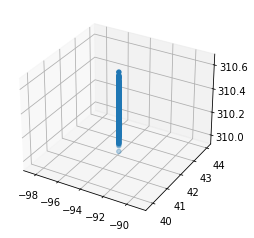

In [22]:
ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2])
plt.show()

##### Cloud points Heatmap

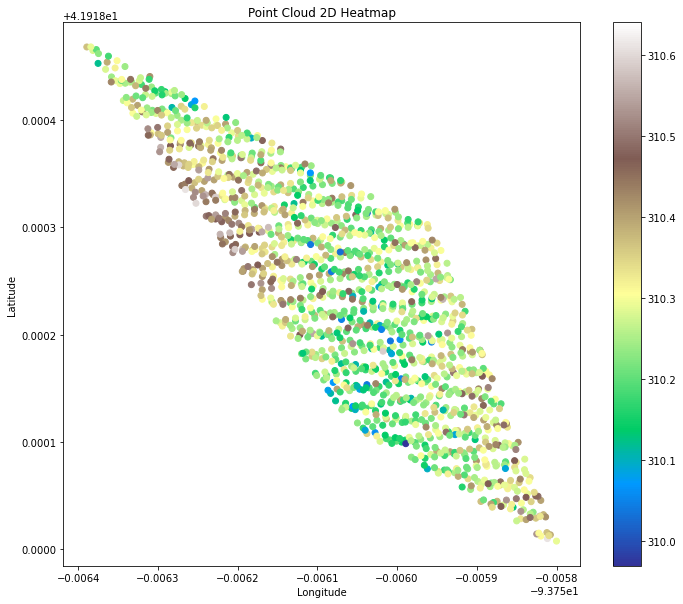

In [27]:
plot_heatmap(geo_df, "Point Cloud 2D Heatmap")

##### 3D scatter plot of the cloud points

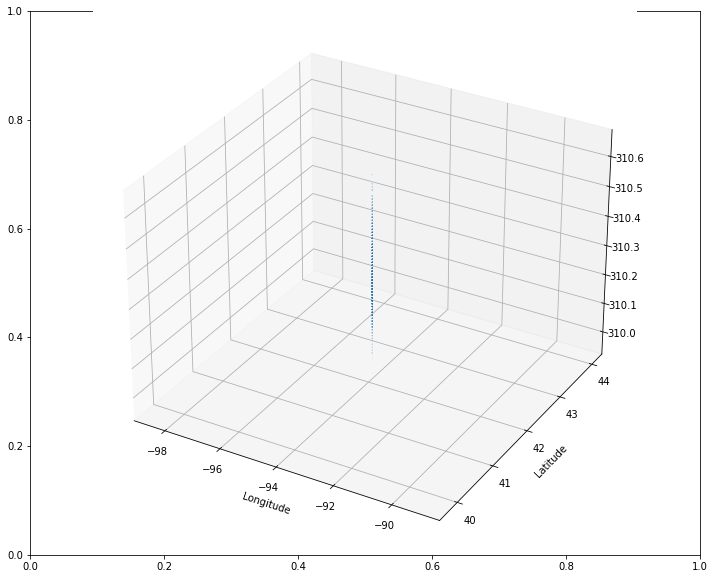

In [28]:
render_3d(points)